# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [2]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

#!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations


### 1.2 Collect Images Using OpenCV

In [3]:
import os
import time 
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [18]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


### 1.3 Annotate Images with LabelMe

In [17]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\danie\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

### 2.3 Load Image into TF Data Pipeline

In [8]:
images = tf.data.Dataset.list_files('data\\images\\*.png')

In [9]:
images.as_numpy_iterator().next()

b'data\\images\\IMG_7573.png'

In [10]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_png(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[161, 150, 135, 255],
        [164, 153, 138, 255],
        [169, 158, 143, 255],
        ...,
        [127, 114,  94, 255],
        [120, 112, 100, 255],
        [121, 115, 106, 255]],

       [[162, 151, 136, 255],
        [167, 156, 140, 255],
        [167, 155, 141, 255],
        ...,
        [121, 109,  89, 255],
        [114, 107,  95, 255],
        [114, 109, 100, 255]],

       [[163, 152, 137, 255],
        [170, 160, 144, 255],
        [167, 155, 140, 255],
        ...,
        [119, 105,  87, 255],
        [114, 107,  94, 255],
        [114, 108,  99, 255]],

       ...,

       [[ 97,  84,  65, 255],
        [ 95,  82,  62, 255],
        [ 95,  82,  62, 255],
        ...,
        [164, 152, 140, 255],
        [162, 154, 146, 255],
        [156, 153, 145, 255]],

       [[ 93,  80,  60, 255],
        [ 93,  79,  60, 255],
        [ 91,  78,  59, 255],
        ...,
        [163, 150, 138, 255],
        [160, 154, 148, 255],
        [159, 153, 147, 255]],

       [[ 91

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = image_generator.next()

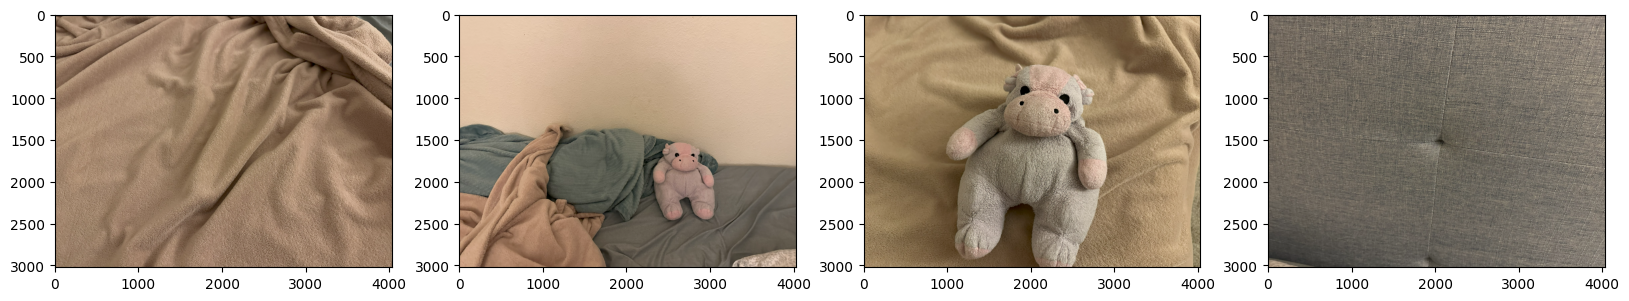

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
30*.7 # 21 to train


In [ ]:
30*.15 # 5 and 4 to test and val at time stamp 52:57

### 3.2 Move the Matching Labels

In [17]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [18]:
import albumentations as alb

In [19]:
widthHeight = 3000
x_value = 5000
y_value = 4500
augmentor = alb.Compose([alb.RandomCrop(width=widthHeight, height=widthHeight), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [20]:

img = cv2.imread(os.path.join('data','train', 'images','IMG_7559.png'))


In [21]:
with open(os.path.join('data', 'train', 'labels', 'IMG_7559.json'), 'r') as f:
    label = json.load(f)



In [22]:
label['shapes'][0]['points']

[[1769.3333333333333, 1072.0], [3602.6666666666665, 2625.3333333333335]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [23]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [24]:
coords

[1769.3333333333333, 1072.0, 3602.6666666666665, 2625.3333333333335]

In [25]:
#coords = list(np.divide(coords, [640,480,640,480]))
coords = list(np.divide(coords, [x_value,y_value,x_value,y_value]))

In [26]:
coords

[0.35386666666666666,
 0.23822222222222222,
 0.7205333333333332,
 0.5834074074074075]

### 4.4 Apply Augmentations and View Results

In [27]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Hippy'])
augmented['bboxes']

[(0.15393013333333336,
  0.41425866666666666,
  0.6467301333333332,
  0.7622053333333333)]

In [28]:
augmented['bboxes'][0][2:]

(0.6467301333333332, 0.7622053333333333)

In [29]:
augmented['bboxes']

[(0.15393013333333336,
  0.41425866666666666,
  0.6467301333333332,
  0.7622053333333333)]

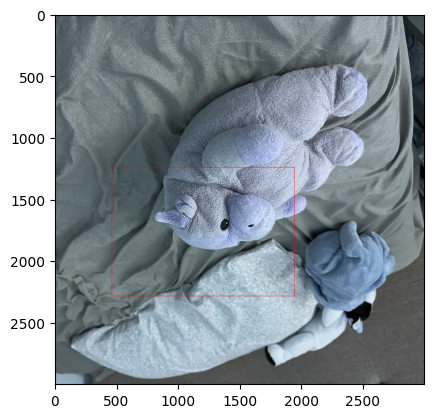

In [30]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [widthHeight,widthHeight]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [widthHeight,widthHeight]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [42]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            if "shapes" in label and isinstance(label["shapes"], list) and len(label["shapes"]) > 0:
                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                #coords = list(np.divide(coords, [640,480,640,480]))
                #added second if statement from chat
                coords = list(np.divide(coords, [x_value,y_value,x_value,y_value]))
        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Hippy'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path) and "shapes" in label and isinstance(label["shapes"], list) and len(label["shapes"]) > 0:
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [31]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (1200,1200)))
train_images = train_images.map(lambda x: x/255)
#resize was 120

In [32]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (1200,1200)))
test_images = test_images.map(lambda x: x/255)

In [33]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (1200,1200)))
val_images = val_images.map(lambda x: x/255)

In [34]:
train_images.as_numpy_iterator().next()

array([[[0.9120098 , 0.85318625, 0.73946077],
        [0.9014706 , 0.8426471 , 0.7289216 ],
        [0.8992647 , 0.84044117, 0.7267157 ],
        ...,
        [0.38137254, 0.3852941 , 0.36568627],
        [0.39313725, 0.3970588 , 0.37745097],
        [0.375     , 0.37892157, 0.35931373]],

       [[0.90539217, 0.84656864, 0.73284316],
        [0.9012255 , 0.842402  , 0.7286765 ],
        [0.90906864, 0.8502451 , 0.73651963],
        ...,
        [0.41911766, 0.42303923, 0.4034314 ],
        [0.41862744, 0.422549  , 0.40294117],
        [0.40808824, 0.4120098 , 0.39240196]],

       [[0.9078431 , 0.8490196 , 0.7352941 ],
        [0.9019608 , 0.84313726, 0.7294118 ],
        [0.907598  , 0.8487745 , 0.735049  ],
        ...,
        [0.44093138, 0.44485295, 0.4252451 ],
        [0.43137255, 0.43529412, 0.41568628],
        [0.4404412 , 0.44436276, 0.4247549 ]],

       ...,

       [[0.48921567, 0.47745097, 0.41862744],
        [0.49240196, 0.48063725, 0.42181373],
        [0.4872549 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [35]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [36]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2527, 0.2345, 0.7456, 0.5825], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [40]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1260, 1260, 300, 300, 240, 240)

### 7.2 Create Final Datasets (Images/Labels)

In [41]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2500)
train = train.batch(8)
train = train.prefetch(4)
#shuffle was 5000

In [42]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(600)
test = test.batch(8)
test = test.prefetch(4)
#shuffle was 1300

In [43]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(400)
val = val.batch(8)
val = val.prefetch(4)
#shuffle was 1000

In [46]:
train.as_numpy_iterator().next()[1]

: 

### 7.3 View Images and Annotations

In [44]:
data_samples = train.as_numpy_iterator()

In [45]:
res = data_samples.next()

: 

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [ ]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

### 8.3 Build instance of Network

In [ ]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

In [ ]:
classes, coords = facetracker.predict(X)

In [ ]:
classes, coords

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [ ]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [ ]:
localization_loss(y[1], coords)

In [ ]:
classloss(y[0], classes)

In [ ]:
regressloss(y[1], coords)

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

### 10.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()